In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import random
import pickle
import seaborn as sns
import math
import sys

### Reads the data into a dataframe and renames the columns to remove unnecessary numbers 

In [14]:

testdownload = pd.read_excel("https://ftp.ncbi.nlm.nih.gov/geo/series/\
GSE124nnn/GSE124548/suppl/GSE124548_AllData_170308_RNAseq_Kopp_Results.xlsx")

In [3]:
testdownload.shape

(15570, 140)

In [15]:
data_df = testdownload
#data_df = pd.read_excel("RNASeqData.xlsx")
#data_df.shape

In [16]:
data_df.shape[0]

15570

In [17]:
data_df = data_df.rename(columns=lambda x: re.sub("w_[0-9]+_O", "w_O",x))
data_df = data_df.rename(columns=lambda x: re.sub("m_[0-9]+_O", "m_O",x))

In [18]:
columns = list(data_df.columns) 

In [19]:
norm_cols = [x for x in columns if "Norm" in x] # get all normalized values
healthy_control = [x for x in norm_cols if "HC" in x] # healthy control norm values
norm_cols_base = [x for x in norm_cols if "Base" in x] # cf without treatment
norm_cols_v2 = [x for x in norm_cols if "V2" in x] # cf with treatment



## Find out how many genes have zeroes

In [20]:
number_of_zeroes = [ list(data_df[norm_cols].values[i]).count(0) for i in range(data_df.shape[0])]
genes_no_zeroes_logic = [number_of_zeroes[i] == 0 for i in range(len(number_of_zeroes))]

Keep only genes with no zeroes

In [21]:
data_df_subset = data_df[genes_no_zeroes_logic]
data_df_subset.shape

(15250, 140)

In [22]:
data_df_subset.head()

,RowID,ID,Description,EntrezID,Class,pre_drug.vs.control_ShrunkenLog2FC,pre_drug.vs.control_MLELog2FC,pre_drug.vs.control_pVal,pre_drug.vs.control_pAdj,post_drug.vs.control_ShrunkenLog2FC,...,Raw_Orkambi_021_Base,Raw_Orkambi_021_V2,Raw_Orkambi_022_Base,Raw_Orkambi_022_V2,Raw_Orkambi_024_Base,Raw_Orkambi_024_V2,Raw_Orkambi_025_Base,Raw_Orkambi_025_V2,Raw_Orkambi_026_Base,Raw_Orkambi_026_V2
0,1,A1BG,alpha-1-B glycoprotein,1,protein_coding,-0.050497,-0.066327,0.691693,0.824882,0.082631,...,113,89,31,125,44,78,113,98,38,70
1,2,A1BG-AS1,A1BG antisense RNA 1,503538,lncRNA,0.004178,0.032895,0.971929,0.986309,0.155902,...,40,36,26,87,23,72,74,55,64,53
2,3,A2M-AS1,A2M antisense RNA 1 (head to head),144571,lncRNA,0.356337,0.932311,0.050847,0.179776,-0.359549,...,16,23,40,104,370,199,81,30,228,33
3,4,AAAS,aladin WD repeat nucleoporin,8086,protein_coding,-0.139005,-0.152091,0.285215,0.495514,-0.118870,...,130,71,28,178,62,219,176,106,160,121
4,5,AACS,acetoacetyl-CoA synthetase,65985,protein_coding,0.138032,0.143003,0.088856,0.251817,0.075925,...,192,157,71,228,130,185,198,114,131,157


In [23]:
def shuffle(grps):
	num_grps = len(grps)
	pool = []
	
	# pool all values
	for i in range(num_grps):
		pool.extend(grps[i])
	# mix them up
	random.shuffle(pool)
	# reassign to groups of same size as original groups
	new_grps = []
	start_index = 0
	end_index = 0
	for i in range(num_grps):
		end_index = start_index + len(grps[i])
		new_grps.append(pool[start_index:end_index])
		start_index = end_index
	return new_grps

In [69]:
def meandiff(grpA, grpB):
	return sum(grpB) / float(len(grpB)) - sum(grpA) / float(len(grpA))

In [70]:
def meanlogFC(grpA, grpB):
    return math.log2( (sum(grpB) / float(len(grpB))) / (sum(grpA) / float(len(grpA))))

In [71]:
def diff2meansig(grpA, grpB):

    # list of lists
    samples = [grpA, grpB]
    a = 0
    b = 1

    observed_mean_diff = meandiff(samples[a], samples[b])
    all_mean_diffs = []

    count = 0
    num_shuffles = 100000

    for i in range(num_shuffles):
        new_samples = shuffle(samples)
        mean_diff = meandiff(new_samples[a], new_samples[b])
        all_mean_diffs.append(mean_diff)
        # if the observed difference is negative, look for differences that are smaller
        # if the observed difference is positive, look for differences that are greater
        if observed_mean_diff < 0 and mean_diff <= observed_mean_diff:
            count = count + 1
        elif observed_mean_diff >= 0 and mean_diff >= observed_mean_diff:
            count = count + 1
    
    return count/num_shuffles

In [72]:
def lfc2meansig(grpA, grpB):

    # list of lists
    samples = [grpA, grpB]
    a = 0
    b = 1

    observed_mean_diff = meanlogFC(samples[a], samples[b])
    all_mean_diffs = []

    count = 0
    num_shuffles = 100000

    for i in range(num_shuffles):
        new_samples = shuffle(samples)
        mean_diff = meanlogFC(new_samples[a], new_samples[b])
        all_mean_diffs.append(mean_diff)
        # if the observed difference is negative, look for differences that are smaller
        # if the observed difference is positive, look for differences that are greater
        if observed_mean_diff < 0 and mean_diff <= observed_mean_diff:
            count = count + 1
        elif observed_mean_diff >= 0 and mean_diff >= observed_mean_diff:
            count = count + 1
    
    return count/num_shuffles

In [24]:
df_norm_hc = data_df_subset[healthy_control]
df_norm_cf = data_df_subset[norm_cols_base]

In [102]:
def avg_diff_sig_test(df_norm_hc, df_norm_cf):
    fullzip = list(zip(df_norm_hc.values, df_norm_cf.values))
    #print(fullzip[0][1])
    #all_p_sig_values = [diff2meansig(fullzip[i][0],fullzip[i][1]) for i in range(100)]
    #all_p_sig_values = [diff2meansig(fullzip[i][0],fullzip[i][1]) for i in range(len(fullzip))]
    all_p_sig_values = [lfc2meansig(fullzip[i][0],fullzip[i][1]) for i in range(len(fullzip))]
    
    return list(all_p_sig_values)

In [103]:
import time
a = time.time()
norm_p_values = avg_diff_sig_test(df_norm_hc, df_norm_cf)
b = time.time()
print(b - a)

58962.5330247879


In [26]:
norm_p_values[0:5]

[0.3615, 0.47724, 0.17866, 0.09279, 0.00214]

In [25]:
pickle.dump( norm_p_values, open( "norm_p_values_unpaired.p", "wb" ) )

**Bonferroni correction**

In this method, we divide the threshold by the number of genes. So, if we take a default threshold of 5% (or 0.05), now our threshold would be `0.05/len(norm_p_values)`

Bonferroni may just be all genes that have only 0.
 - count the number of p-values that are 0
violin plot of a set, 5-10 genes to see if they are really separate. 
confirm that their diagnostics are also present here.
Take top 5 genes to do machine learning.
 - do decision tree and random forest


In [27]:
norm_p_values = pickle.load( open( "norm_p_values_unpaired.p", "rb" ) )
count_significant_genes_bonferroni = 0
for i, ele in enumerate(norm_p_values):
  if ele < (0.05/len(norm_p_values)):
    count_significant_genes_bonferroni += 1
    #print(i+1)
print("Number of significant genes: ", count_significant_genes_bonferroni)

Number of significant genes:  613


In [28]:
norm_p_values.count(0)

613

In [29]:
tmp_sorted_indices = np.argsort(norm_p_values)

In [51]:
# bonferroni is 1248, so let's take the top 1248 and compare

bon_sig_index = tmp_sorted_indices[:613]

bon_sig_genes = [data_df_subset["ID"].iloc[bon_sig_index[i]] for i in range(len(bon_sig_index))]
bon_sig_genes[:5]

['AKAP10', 'YTHDF3', 'TBC1D1', 'CARD6', 'TBC1D14']

**Benjamini–Hochberg procedure**

 Put the individual P values in order, from smallest to largest. The smallest P value has a rank of i=1, then next smallest has i=2, etc. Compare each individual P value to its Benjamini-Hochberg critical value, (i/m)Q, where i is the rank, m is the total number of tests, and Q is the false discovery rate you choose. The largest P value that has P<(i/m)Q is significant, and all of the P values smaller than it are also significant, even the ones that aren't less than their Benjamini-Hochberg critical value.

In [31]:
def benjamin_hochberg_corrected_p_values(p_values, fdr):
  num_genes = len(p_values)
  sorted_indices = np.argsort(p_values)
  sorted_p_values = sorted(p_values)
  benjamini_hochberg_critical_values = [((i+1)/num_genes)*fdr for i in range(num_genes)]
  for i, p_value in reversed(list(enumerate(sorted_p_values))):
    if p_value < benjamini_hochberg_critical_values[i]:
      break
  return i, sorted_indices

In [32]:
norm_p_values = pickle.load( open( "norm_p_values_unpaired.p", "rb" ) )
i, sorted_indices = benjamin_hochberg_corrected_p_values(norm_p_values, 0.05)
num_sig_genes = i+1
print("Number of significant genes: ", num_sig_genes)

Number of significant genes:  5338


In [33]:
significant_genes = []

significant_genes = [data_df_subset["ID"].iloc[sorted_indices[i]] for i in range(len(sorted_indices))]
significant_genes[:5]

['AKAP10', 'YTHDF3', 'TBC1D1', 'CARD6', 'TBC1D14']

In [35]:
print(data_df_subset.loc[data_df_subset['ID'].isin(significant_genes)][['RowID', 'ID', 'Description']])

       RowID        ID                                        Description
0          1      A1BG                             alpha-1-B glycoprotein
1          2  A1BG-AS1                               A1BG antisense RNA 1
2          3   A2M-AS1                 A2M antisense RNA 1 (head to head)
3          4      AAAS                       aladin WD repeat nucleoporin
4          5      AACS                         acetoacetyl-CoA synthetase
...      ...       ...                                                ...
15565  15566      ZXDC                           ZXD family zinc finger C
15566  15567    ZYG11B       zyg-11 family member B, cell cycle regulator
15567  15568       ZYX                                              zyxin
15568  15569     ZZEF1  zinc finger ZZ-type and EF-hand domain contain...
15569  15570      ZZZ3                   zinc finger ZZ-type containing 3

[15250 rows x 3 columns]


In [36]:
#draw histogram

def draw_hist(d, observed):
    print(observed)
    hist,bin_edges = np.histogram(d,bins =100)    
    plt.figure(figsize=[8,8])
    plt.bar(bin_edges[:-1], hist, width = 0.01, color='#0504aa',alpha=0.7)
    #plt.xlim(min(min(bin_edges),-4), max(max(bin_edges),4))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Normal Distribution Histogram',fontsize=15)
    plt.axvline(x=observed, color='r', linestyle='dashed', linewidth=2)
    plt.show()

0.05


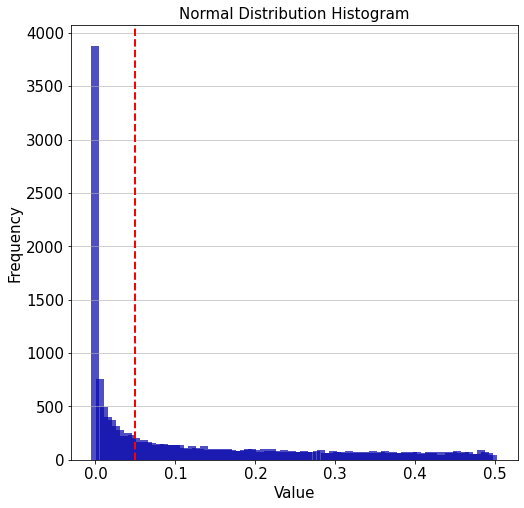

In [37]:
draw_hist(norm_p_values, 0.05)

In [38]:
norm_hc_cf_with_genename = ["ID"]
norm_hc_cf_with_genename.extend(healthy_control)
norm_hc_cf_with_genename_melt = data_df_subset[norm_hc_cf_with_genename].melt("ID")
norm_hc_cf_with_genename_melt.variable="HC"
#print(norm_hc_cf_with_genename_melt.shape)


norm_cf_with_genename = ["ID"]
norm_cf_with_genename.extend(norm_cols_v2)
norm_cf_with_genename_melt = data_df_subset[norm_cf_with_genename].melt("ID")
norm_cf_with_genename_melt.variable="CF"
#print(norm_cf_with_genename_melt.shape)

norm_hc_cf_with_genename_melt = norm_hc_cf_with_genename_melt.append(norm_cf_with_genename_melt, ignore_index=True)
norm_hc_cf_with_genename_melt.head()

,ID,variable,value
0,A1BG,HC,77.278533
1,A1BG-AS1,HC,46.748742
2,A2M-AS1,HC,70.600142
3,AAAS,HC,153.603011
4,AACS,HC,189.857138


In [70]:
#list(norm_hc_cf_with_genename_melt.ID.values)

## Violin Plots

In [71]:
#norm_hc_cf_with_genename_melt.

In [39]:
#data_df.iloc(tmp_sorted_indices[0])
#genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top_sorted_genes[2:3])]
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(bon_sig_genes[2:3])]


<AxesSubplot:xlabel='ID', ylabel='value'>

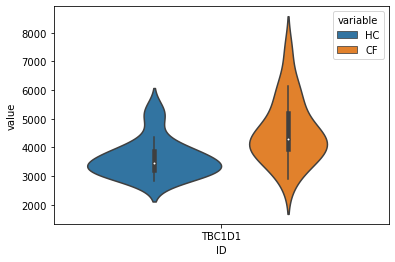

In [40]:
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)

In [41]:
tmp_sorted_p_values = sorted(norm_p_values)

In [42]:
tmp_sorted_p_values.count(0)

613

In [43]:
tmp_critical_values = [((i+1)/15000)*0.05 for i in range(15000)]

In [44]:
tmp_critical_values[:10]

[3.3333333333333337e-06,
 6.6666666666666675e-06,
 1e-05,
 1.3333333333333335e-05,
 1.6666666666666667e-05,
 2e-05,
 2.3333333333333336e-05,
 2.666666666666667e-05,
 2.9999999999999997e-05,
 3.3333333333333335e-05]

# Compare results to published.

In [52]:
#np.count_nonzero(abs(2) < abs(a))
published_sig_logic = data_df_subset['pre_drug.vs.control_pAdj'] < 0.05
np.count_nonzero(published_sig_logic)

1944

In [53]:
published_sig_index = [i for i, x in enumerate(published_sig_logic) if x]

In [54]:
published_significant_genes = []
published_significant_genes = [data_df_subset["ID"].iloc[published_sig_index[i]] for i in range(len(published_sig_index))]
published_significant_genes[:5]

['ABAT', 'ABCA13', 'ABCA2', 'ABHD13', 'ABHD14A']

In [55]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

sig_intersection = intersection(published_significant_genes, significant_genes)

In [56]:
len(sig_intersection)

1944

In [57]:
len(intersection(bon_sig_genes, published_significant_genes))

577

In [58]:
import statsmodels.stats.multitest as ssm
norm_p_values_np = np.array(norm_p_values, float)

rej, s_adjpval = ssm.multipletests(norm_p_values_np, alpha=0.05, method="s")[:2]
rej, fdr_adjpval = ssm.multipletests(norm_p_values_np, alpha=0.05, method="fdr_i")[:2]

In [59]:
tmp_sorted_s_adjpval = sorted(s_adjpval)
tmp_sorted_s_adjpval[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [60]:
tmp_sorted_fdr_adjpval = sorted(fdr_adjpval)
tmp_sorted_fdr_adjpval[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [61]:
sum(np.array(tmp_sorted_fdr_adjpval)<0.05)

5338

In [62]:
pd.DataFrame([tmp_sorted_p_values[:10],tmp_sorted_fdr_adjpval[:10],tmp_sorted_s_adjpval[:10]])

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Healthy control vs CF confidence interval

In [63]:
# We will only look at the confidence intervals of the genes that had 0 events.
data_df_subset_bon = data_df_subset[data_df_subset.ID.isin(bon_sig_genes)]
df_norm_hc_bon_sig = df_norm_hc[data_df_subset.ID.isin(bon_sig_genes)]
df_norm_cf_bon_sig = df_norm_cf[data_df_subset.ID.isin(bon_sig_genes)]
print(df_norm_cf_bon_sig.shape,df_norm_hc_bon_sig.shape)

(613, 20) (613, 20)


In [64]:
def bootstrap(x):
	samp_x = []
	for i in range(len(x)):
		samp_x.append(random.choice(x))
	return samp_x

In [65]:
def diff2meanconf(grpA, grpB, conf_interval):
    # list of lists
    samples = [grpA, grpB] 
    a = 0
    b = 1

    # for genes that have more than 50% missing data
    # in either sample, return the value 0.
    grpA_with_zero = list(grpA).count(0) / len(grpA)
    grpB_with_zero = list(grpB).count(0) / len(grpB)
    if (grpA_with_zero >= 0.01):
        return [0,0]
    elif (grpB_with_zero >= 0.01):
        return [0,0]
    else:
        observed_mean_diff = meanlogFC(samples[a], samples[b])
        num_resamples = 1000   # number of times we will resample from our original samples
        out = []                # will store results of each time we resample
        for i in range(num_resamples):
            # get bootstrap samples for each of our groups
            # then compute our statistic of interest
            # append statistic to out
            bootstrap_samples = []  # list of lists
            for sample in samples:
                bootstrap_samples.append(bootstrap(sample))
            # now we have a list of bootstrap samples, run meandiff
            out.append(meanlogFC(bootstrap_samples[a], bootstrap_samples[b]))
        out.sort()
        tails = (1 - conf_interval) / 2
        # in case our lower and upper bounds are not integers,
        # we decrease the range (the values we include in our interval),
        # so that we can keep the same level of confidence
        lower_bound = int(math.ceil(num_resamples * tails))
        upper_bound = int(math.floor(num_resamples * (1 - tails)))
        return([out[lower_bound], out[upper_bound]])

In [73]:
diff2meanconf(list(df_norm_hc_bon_sig.values[1]),list(df_norm_hc_bon_sig.values[1]),.90)

[-0.2150965337945239, 0.18247487449803246]

In [74]:
fullzip = list(zip(df_norm_hc_bon_sig.values, df_norm_cf_bon_sig.values))
all_conf_intervals = [diff2meanconf(fullzip[i][0],fullzip[i][1], 0.90) for i in range(len(fullzip))]
   

In [76]:
pickle.dump( all_conf_intervals, open( "all_conf_intervals.p", "wb" ) )

In [77]:
all_conf_intervals = pickle.load( open( "all_conf_intervals.p", "rb" ) )

In [78]:
max_conf = [abs(max(all_conf_intervals[i], key=abs)) for i in range(len(all_conf_intervals))]

In [79]:
sorted_max_conf = sorted(max_conf, reverse=True)
#sorted_max_conf[:10]
sorted_max_conf_index = np.argsort(max_conf)

top10_conf_index = sorted_max_conf_index[::-1][:10]
top10_conf_index

array([379, 270, 316, 335, 215,  27, 508, 181, 394, 174])

In [80]:
top10_ci_genes = [data_df_subset_bon["ID"].iloc[top10_conf_index[i]] for i in range(len(top10_conf_index))]

In [81]:
top10_ci_genes

['OLAH',
 'LOC105372578',
 'MCEMP1',
 'MMP9',
 'IL1R2',
 'ANXA3',
 'SOCS3',
 'G0S2',
 'PFKFB3',
 'FKBP5']

In [82]:
top10_ci_gene_description = [data_df_subset_bon["Description"].iloc[top10_conf_index[i]] for i in range(len(top10_conf_index))]
top10_ci_gene_description

['oleoyl-ACP hydrolase',
 nan,
 'mast cell-expressed membrane protein 1',
 'matrix metallopeptidase 9',
 'interleukin 1 receptor type 2',
 'annexin A3',
 'suppressor of cytokine signaling 3',
 'G0/G1 switch 2',
 '6-phosphofructo-2-kinase/fructose-2,6-biphosphatase 3',
 'FK506 binding protein 5']

In [83]:
top10conf = [all_conf_intervals[i] for i in top10_conf_index]

In [84]:
top10conf

[[1.8230629035565014, 4.733720738506132],
 [1.8554714585472232, 3.402753961946862],
 [1.7771704389195209, 2.8806887850455127],
 [1.8012407220742266, 2.7356793645219883],
 [1.0346081331472272, 2.50877695441414],
 [1.4647597913683876, 2.4845374779431824],
 [1.5366356061764157, 2.429375497132998],
 [1.5189916056832473, 2.3824895939148623],
 [1.5792492265992721, 2.3317526499261856],
 [0.849195895768444, 2.291423504563962]]

In [85]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[3:4])]


<AxesSubplot:xlabel='ID', ylabel='value'>

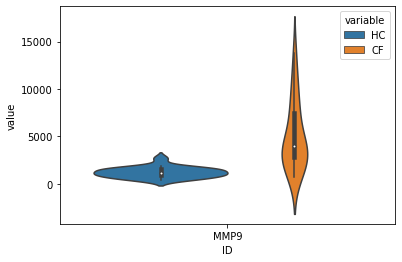

In [86]:
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


<AxesSubplot:xlabel='ID', ylabel='value'>

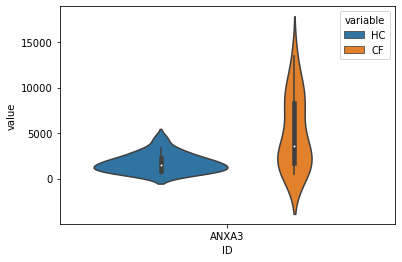

In [87]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[5:6])]
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


<AxesSubplot:xlabel='ID', ylabel='value'>

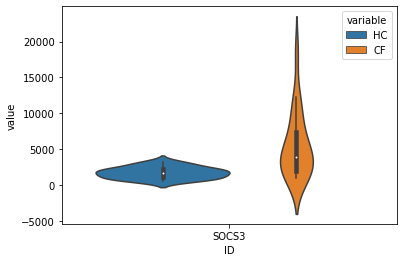

In [88]:
genestoplot=norm_hc_cf_with_genename_melt[norm_hc_cf_with_genename_melt.ID.isin(top10_ci_genes[6:7])]
sns.violinplot(x="ID", y="value", hue="variable",data=genestoplot)


## Machine Learning Models

First we need to make subset of the dataframe to contain only our top 10 genes

In [89]:
data_df_subset_bon_top10ci = data_df_subset[data_df_subset.ID.isin(top10_ci_genes)]
df_norm_hc_bon_sig_top10ci = df_norm_hc[data_df_subset.ID.isin(top10_ci_genes)]
df_norm_cf_bon_sig_top10ci = df_norm_cf[data_df_subset.ID.isin(top10_ci_genes)]
print(df_norm_hc_bon_sig_top10ci.shape,df_norm_cf_bon_sig_top10ci.shape)

(10, 20) (10, 20)


In [90]:
df_norm_healthy_T = df_norm_hc_bon_sig_top10ci.T
labels_healthy = [1]*20

df_norm_base_T = df_norm_cf_bon_sig_top10ci.T
labels_patient = [0]*20

In [91]:
X1 = df_norm_healthy_T.values
X2 = df_norm_base_T.values
Y1 = np.zeros((1,20))
Y2 = np.ones((1,20))

In [92]:
X = np.concatenate((X1, X2), axis=0)
X.shape

(40, 10)

In [93]:
Y = np.concatenate((Y1, Y2), axis=1)
Y = np.reshape(Y, 40)
Y.shape

(40,)

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [95]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

In [96]:
def randomforest(X_train, X_test, Y_train, Y_test):
    clf = RandomForestClassifier().fit(X_train, Y_train)
    Y_train_predicted = clf.predict(X_train)
    train_score = f1_score(Y_train, Y_train_predicted)
    Y_test_predicted = clf.predict(X_test)
    test_score = f1_score(Y_test, Y_test_predicted)
    return [train_score, test_score]

In [98]:
from sklearn.inspection import permutation_importance
score=np.zeros(shape=(100,2))
feature_imp_sample=[]
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y)
    score[i,]=(randomforest(X_train, X_test, Y_train, Y_test))
    clf = RandomForestClassifier().fit(X_train, Y_train)
    perm_imp=permutation_importance(clf, X_train, Y_train, n_repeats=20, scoring='f1')
    feature_imp_sample.append(perm_imp.importances_mean)

score_sorted = np.sort(score, axis=0)

print("5%", score_sorted[5])
print("95%", score_sorted[95])

5% [1.         0.57142857]
95% [1. 1.]


In [99]:
sum(score[:,1])/len(score[:,1])

0.8303730158730153

In [129]:
clf = RandomForestClassifier().fit(X_train, Y_train)
#result = permutation_importance(clf, X_train, Y_train, n_repeats=5, scoring='f1')
result = permutation_importance(clf, X, Y, n_repeats=10)


<AxesSubplot:xlabel='value', ylabel='Gene'>

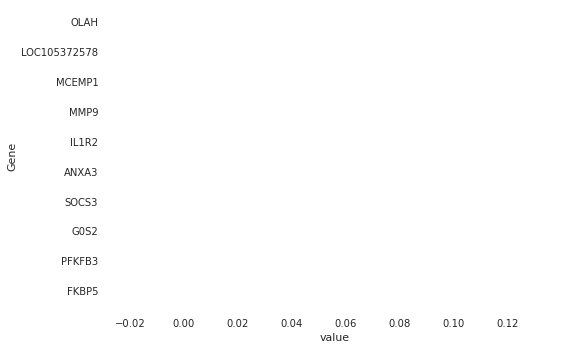

In [128]:
feature_imp_sample[:2]
feature_imp_sample_df = pd.DataFrame(data=feature_imp_sample)
feature_imp_sample_df.columns=top10_ci_genes
feature_imp_sample_melt = feature_imp_sample_df.melt(var_name="Gene")
#feature_imp_sample_melt.head()
sns.violinplot(y="Gene",x="value",data=feature_imp_sample_melt)

In [130]:
clf.feature_importances_

array([0.01976983, 0.12711144, 0.05535558, 0.18449754, 0.03179215,
       0.05391421, 0.28714244, 0.0211416 , 0.09485545, 0.12441976])

<AxesSubplot:xlabel='important', ylabel='genes'>

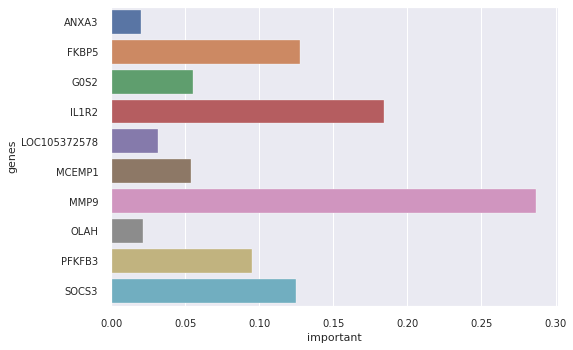

In [131]:
clf_feature_imp = {"important" : list(clf.feature_importances_),
                   "genes" : data_df_subset_bon_top10ci.ID.values}
clf_feature_imp_df = pd.DataFrame(data=clf_feature_imp)
#clf_feature_imp_df
sns.barplot(y="genes",x="important", data=clf_feature_imp_df)

In [132]:
result.importances
feature_imp_data = {'variables':data_df_subset_bon_top10ci.ID.values,
                 'mean':result.importances_mean,
                 'sd':result.importances_std}
feature_imp_df = pd.DataFrame(data=feature_imp_data)

In [133]:
data_df_subset_bon_top10ci.ID.values

array(['ANXA3', 'FKBP5', 'G0S2', 'IL1R2', 'LOC105372578', 'MCEMP1',
       'MMP9', 'OLAH', 'PFKFB3', 'SOCS3'], dtype=object)

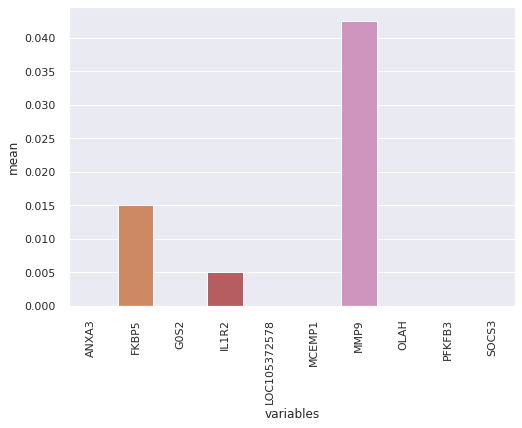

In [134]:
sns.set(font_scale=1)

feature_plot = sns.barplot(x='variables',y='mean',data=feature_imp_df)
feature_plot.set_xticklabels(feature_imp_df['variables'],rotation=90)
plt.savefig("rnaseq_important_variable.png")

In [135]:
score[:5]

array([[1.        , 0.75      ],
       [1.        , 0.85714286],
       [1.        , 0.8       ],
       [1.        , 0.75      ],
       [1.        , 0.75      ]])

/home/mkatari/miniconda3/envs/jupyterlab/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Random Forest')

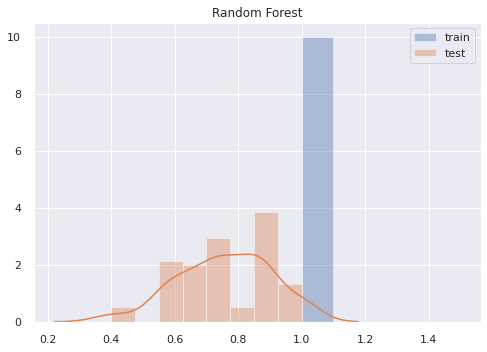

In [136]:
sns.set(font_scale=1)
sns.distplot(score[:,0], label="train")
sns.distplot(score[:,1], label="test")
plt.legend()
plt.title("Random Forest")

In [137]:
from sklearn.tree import DecisionTreeClassifier

def decisiontree(X_train, X_test, Y_train, Y_test):
    clf = DecisionTreeClassifier(criterion="gini").fit(X_train, Y_train)
    Y_train_predicted = clf.predict(X_train)
    train_score = f1_score(Y_train, Y_train_predicted)
    Y_test_predicted = clf.predict(X_test)
    test_score = f1_score(Y_test, Y_test_predicted)
    return [train_score, test_score]

In [115]:
score=np.zeros(shape=(100,2))
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y)
    score[i,]=(decisiontree(X_train, X_test, Y_train, Y_test))

score_sorted = np.sort(score, axis=0)

print("5%", score_sorted[5])
print("95%", score_sorted[95])

5% [1.         0.57142857]
95% [1. 1.]


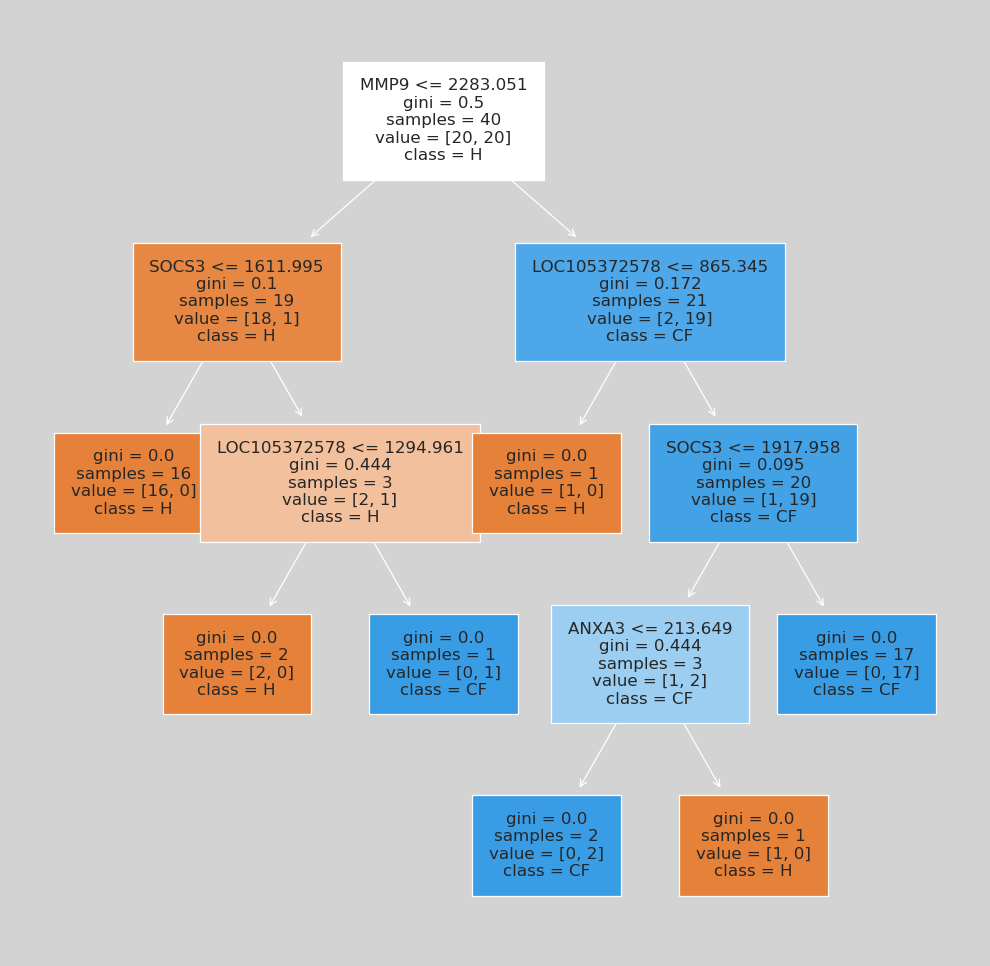

In [138]:
from sklearn import tree
plt.style.use('seaborn-notebook')
clf_gini = DecisionTreeClassifier(criterion="gini").fit(X, Y)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300, facecolor="lightgray")
plt.rcParams['lines.markeredgecolor']='black'
plt.rcParams['lines.linewidth']=500

tree.plot_tree(clf_gini,
               feature_names = top10_ci_genes,
               class_names= ["H","CF"],
               filled = True,
              fontsize=4,
              )
fig.savefig('rnaseq_decision_tree.png')

In [117]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [204]:
X

array([[1.19543213e+03, 2.67135671e+01, 8.87272050e+01, 1.19447807e+03,
        7.53704215e+01, 1.26889444e+02, 1.04278317e+03, 2.86216790e+00,
        8.57696315e+02, 1.44539479e+03],
       [2.23662547e+03, 3.93623590e+01, 1.84159608e+02, 2.24224867e+03,
        1.27927667e+02, 1.27927667e+02, 1.58714655e+03, 1.40579854e+00,
        1.68414665e+03, 2.24084287e+03],
       [1.91761143e+03, 4.78841715e+01, 2.43161808e+02, 1.97522207e+03,
        8.08045394e+01, 1.09983956e+02, 1.26369321e+03, 4.48914108e+00,
        1.49862493e+03, 2.14655763e+03],
       [7.63621243e+02, 4.26869018e+01, 7.11448363e+01, 1.32708835e+03,
        6.07102603e+01, 6.73504450e+01, 4.92322267e+02, 1.32803694e+01,
        8.89784752e+02, 9.10653904e+02],
       [2.20589579e+03, 4.36171266e+01, 2.35047849e+02, 2.20104944e+03,
        1.58314015e+02, 1.41351799e+02, 1.24551128e+03, 3.23089826e+00,
        1.25924260e+03, 2.48132987e+03],
       [1.54452200e+03, 7.55605189e+01, 1.30809070e+02, 1.54370953e+03,
   